In [1]:
#Import dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
def make_embedding():
    input = Input(shape=(224,224,3), name='flood_image')

    #First convulutional layer
    c1 = Conv2D(64, (10,10), activation='relu')(input)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #Second convulutional layer
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #Third and final convulutional layer
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #Final layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[input], outputs=[d1], name='embedding')

In [3]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flood_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 215, 215, 64)      19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 102, 128)     401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       26

In [4]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [5]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(224,224,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(224,224,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [6]:
# Setup paths
ANC_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Network/Data_Siamese/Anchor'
NEG_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Network/Data_Siamese/Negative'
POS_PATH = '/content/drive/MyDrive/Third_Year_Project/Siamese_Network/Data_Siamese/Positive'

#Get our anchor, negative and positive data
#This is done by creating an iterator for this path up to file 500
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.png').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.png').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.png').take(500)

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (224,224))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

samples = data.as_numpy_iterator()

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [10]:
siamese_model = make_siamese_model()
siamese_model.summary()
binary_cross_loss = tf.losses.BinaryCrossentropy()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         463633728   ['input_img[0][0]',              
                                                                  'validation_img[0][

In [11]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [13]:
test_batch = train_data.as_numpy_iterator()

In [14]:
batch_1 = test_batch.next()

In [15]:
X = batch_1[:2]

In [16]:
y = batch_1[2]

In [17]:
tf.losses.BinaryCrossentropy??

In [18]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [19]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [20]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [21]:
EPOCHS = 50

In [22]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 71s 1s/step
0.6972248 0.44126076 0.5923077

 Epoch 2/50
44/44 [==============================] - 59s 1s/step
0.6918385 0.16239317 0.5480769

 Epoch 3/50
44/44 [==============================] - 59s 1s/step
0.6974073 0.15428571 0.7012987

 Epoch 4/50
44/44 [==============================] - 59s 1s/step
0.7217369 0.23714286 0.5886525

 Epoch 5/50
44/44 [==============================] - 59s 1s/step
0.6970935 0.04034582 0.7

 Epoch 6/50
44/44 [==============================] - 60s 1s/step
0.6698132 0.0057971017 0.4

 Epoch 7/50
44/44 [==============================] - 59s 1s/step
0.66927654 0.0 0.0

 Epoch 8/50
44/44 [==============================] - 59s 1s/step
0.6762174 0.0 0.0

 Epoch 9/50
44/44 [==============================] - 58s 1s/step
0.679677 0.0 0.0

 Epoch 10/50
44/44 [=

[[0.5021772 ]
 [0.5021696 ]
 [0.5021653 ]
 [0.50209856]
 [0.5021693 ]
 [0.5021645 ]
 [0.5021401 ]
 [0.5021655 ]
 [0.502136  ]
 [0.50213313]
 [0.50218475]
 [0.50217676]
 [0.50213003]
 [0.50212604]
 [0.5021654 ]
 [0.5021389 ]]
1.0 0.45333335


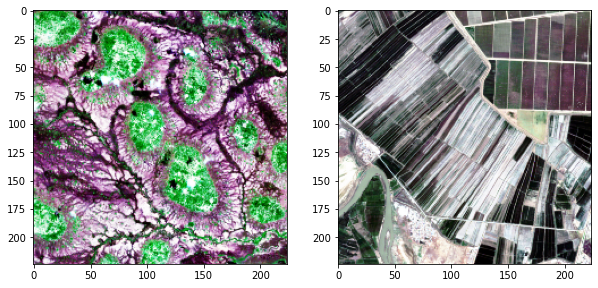

In [23]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

y_hat = siamese_model.predict([test_input, test_val])

print(y_hat)

# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [24]:
# Save weights
siamese_model.save('/content/drive/MyDrive/Third_Year_Project/Siamese_Network/siamesemodelv2.h5')
L1Dist
# Reload model 
siamese_model = tf.keras.models.load_model('/content/drive/MyDrive/Third_Year_Project/Siamese_Network/siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.50212085],
       [0.5021174 ],
       [0.50210106],
       [0.5021695 ],
       [0.50212777],
       [0.50209653],
       [0.50218123],
       [0.5021842 ],
       [0.50208145],
       [0.5021898 ],
       [0.5021264 ],
       [0.50217104]], dtype=float32)

In [25]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         463633728   ['input_img[0][0]',              
                                                                  'validation_img[0][

In [26]:
import h5py

filename = "/content/drive/MyDrive/Third_Year_Project/Siamese_Network/siamesemodelv2.h5"

h5 = h5py.File(filename,'r')

futures_data = h5  # VSTOXX futures data

print(h5)

h5.close()

<HDF5 file "siamesemodelv2.h5" (mode r)>
